Time Series Forecasting Using SARIMAX (with Log Transform + Exogenous Variable)

Time-series forecasting plays a crucial role in business decision-making, especially when seasonality and external factors influence the demand. In this project, I build a SARIMAX (Seasonal ARIMA with Exogenous Regressors) model to forecast airline passenger traffic.

The dataset used here contains monthly passenger counts for 3 years, along with a custom-built exogenous variable called is_summer, which marks June, July, and August as summer months (1) and the rest as 0. The idea behind adding this exogenous variable is simple:

 Summer months exhibit higher travel demand
 The model should learn this additional seasonal effect through a β coefficient
 During future summers, the model should automatically up-predict passenger values

To stabilize the variance and make the series more suitable for modeling, we apply a log transformation to the target variable. This makes the seasonal fluctuations more “additive” and helps SARIMAX capture trend + seasonality more efficiently.

This notebook performs the following steps:

 Load and preprocess the dataset

 Create the exogenous regressors

 Apply log transformation

 Perform ADF and KPSS stationarity tests

 Use Auto-ARIMA to automatically determine the best (p,d,q) and (P,D,Q,m)

 Validate the model on the last 12 months

 Refit the model on full data

 Forecast the next 36 months

 Export results to CSV and visualize the predictions

In [ ]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error


In [ ]:
# Expecting columns like  month (index), air (target), is_summer (exog 0/1)
df = pd.read_csv("airline_with_summer.csv", parse_dates=["month"], index_col="month")
df = df.asfreq("MS")  # month-start frequency

In [ ]:
df.head()

,air,is_summer
month,,
1949-01-01,112,0
1949-02-01,118,0
1949-03-01,132,0
1949-04-01,129,0
1949-05-01,121,0


In [ ]:
df.isna().sum() # no null values

air          0
is_summer    0
dtype: int64

In [ ]:
df.describe()

,air,is_summer,y_log
count,144.000000,144.000000,144.000000
mean,280.298611,0.250000,5.542176
std,119.966317,0.434524,0.441456
min,104.000000,0.000000,4.644391
25%,180.000000,0.000000,5.192957
50%,265.500000,0.000000,5.581599
75%,360.500000,0.250000,5.887489
max,622.000000,1.000000,6.432940


In [ ]:
# Why i am doing  log transform

# Many real-world time series (like airline passengers) show multiplicative patterns that means  the ups/downs grow in proportion to the size of
#the series.
# Exampel is like  seasonal jumps are small in early years and much bigger in later years.


# value = trend × seasonality × noise



# Log transform converts this into an additive pattern, which SARIMAX handles much better:

# log(value) = log(trend) + log(seasonality) + log(noise)

# THis handles systematic change in Variance

In [ ]:
df["y_log"] = np.log(df["air"])

In [ ]:
# In this step, we apply a log transformation to the passenger series air to stabilize the variance and convert the

# multiplicative seasonal pattern into an additive structure. This makes the series easier for SARIMAX to model.

# After the transformation, we perform an additive seasonal decomposition to break the log series into four components

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

def susnata_adf(series):
    result = adfuller(series)
    p = result[1]
    print("ADF Test p-value:", p)
    if p < 0.05:
        print("✅ ADF: Stationary (p < 0.05)")
    else:
        print("❌ ADF: Non-Stationary (p >= 0.05)")

def susnata_kpss(series):
    result = kpss(series, regression='c', nlags='auto')
    p = result[1]
    print("\nKPSS Test p-value:", p)
    if p > 0.05:
        print("✅ KPSS: Stationary (p > 0.05)")
    else:
        print("❌ KPSS: Non-Stationary (p <= 0.05)")

print(" Stationarity Check on log series ")
susnata_adf(df["y_log"])
susnata_kpss(df["y_log"])

 Stationarity Check on log series 
ADF Test p-value: 0.4223667747703897
❌ ADF: Non-Stationary (p >= 0.05)

KPSS Test p-value: 0.01
❌ KPSS: Non-Stationary (p <= 0.05)


###  Stationarity Test Summary

From both the **Augmented Dickey–Fuller (ADF)** and **Kwiatkowski–Phillips–Schmidt–Shin (KPSS)** tests,
it is clear that the **log-transformed series remains non-stationary**.  

The ADF test failed to reject its null hypothesis (p > 0.05), while the KPSS test rejected its null hypothesis (p < 0.05),  
indicating that the series still contains trend and seasonal components.

They are like checking the non stationary aspect from both sides of a coin

This result is completely expected for airline passenger data, which typically exhibits a strong upward trend and repeating yearly seasonality.  
The log transformation has stabilized variance but has not removed the trend or seasonality.

 Therefore, the next step is to pass this **non-stationary log series** directly into **Auto-ARIMA**,  
which will automatically determine the optimal levels of differencing (**d** and **D**) along with the best AR and MA parameters (**p**, **q**, **P**, **Q**) to make the series stationary internally before building the forecasting model.

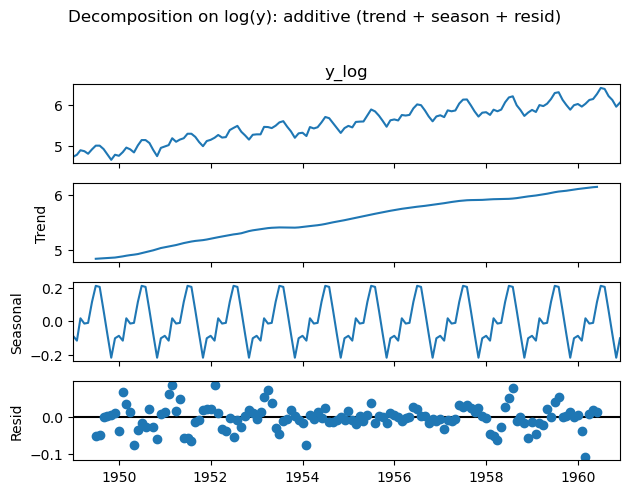

In [ ]:
decomp = seasonal_decompose(df["y_log"], model="additive", period=12)
decomp.plot()
plt.suptitle("Decomposition on log(y): additive (trend + season + resid)", y=1.02)
plt.tight_layout(); plt.show()

In [ ]:
# Observed (the original log series),

# Trend (long-term upward movement in air travel),

# Seasonal (repeating 12-month airline travel cycle), and

# Residuals (random noise).

# The plot clearly shows the consistent seasonal spikes every year, a smooth upward trend, and residuals centered around zero,


# confirming that the series is now well-behaved and suitable for SARIMAX modeling.


# This step helps me visually verify that the log transformation successfully stabilized the pattern before fitting the forecasting model.

# After applying the log transformation, the ADF and KPSS tests still indicated that the series is non-stationary.
# However, the additive decomposition of the log-transformed data clearly shows three key components:
#  A clear upward trend (indicating long-term growth in air travel)
#  A strong, repeating seasonal pattern (12-month cycle)
# Residuals

# This means the log transformation has stabilized the variance and converted the data into an additive structure,
# but the series still contains trend and seasonality components.
# Therefore, it is not yet stationary, but it has become well-behaved and suitable for SARIMAX modeling,
# where differencing (d, D) will handle the remaining trend and seasonal components.

In [ ]:
df[["air","y_log"]].head()

,air,y_log
month,,
1949-01-01,112,4.718499
1949-02-01,118,4.770685
1949-03-01,132,4.882802
1949-04-01,129,4.859812
1949-05-01,121,4.795791


In [ ]:
df.head()  # Summer is my Exogenous variable

,air,is_summer,y_log
month,,,
1949-01-01,112,0,4.718499
1949-02-01,118,0,4.770685
1949-03-01,132,0,4.882802
1949-04-01,129,0,4.859812
1949-05-01,121,0,4.795791


In [ ]:
H = 12  # 12-month validation holdout
train = df.iloc[:-H]
valid = df.iloc[-H:]

y_tr = train["y_log"]
y_va = valid["y_log"]

X_tr = train[["is_summer"]]
X_va = valid[["is_summer"]]

In [ ]:
# Rolling origin / Walk-Forward Temporal Holdout

# In this step, i  perform a rolling walk-forward style temporal holdout by keeping the last 12 months as the validation window.

# The earlier data is used for training, where the model learns trend, seasonality, and the impact of the exogenous variable.

# The validation set simulates a true future forecast which  the model predicts forward while only using past information.


# This approach ensures strict time-ordering, prevents data leakage, and mirrors a realistic rolling


# forecast environment used in production time-series systems.

In [ ]:
# Exogenous Regressor  is_summer

# The dataset includes an additional external feature called is_summer, which acts as an exogenous regressor

# in the SARIMAX model.


# This variable takes the value 1 during the summer months (June–August) and 0 otherwise.
# Summer months typically experience higher airline traffic due to vacations, tourism,

#  and holiday travel, which is an external factor not captured by the time series alone.

# By including is_summer as an exogenous regressor, the model receives extra information about real-world seasonal

# demand shifts, allowing SARIMAX to adjust the forecast upward during summer and downward during non-summer months.

# This improves both interpretability and forecast accuracy.

In [ ]:
# AUTO-ARIMA to find best (p,d,q)(P,D,Q)m


from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(
    df["y_log"],          # Target variable (log-transformed)
    exogenous=df[["is_summer"]],  # Exogenous regressor which is summer
    start_p=0, start_q=0,         # Lower bounds for p and q
    max_p=5, max_q=5,             # Upper bounds for p and q
    start_P=0, max_P=2,           # Seasonal AR terms limits
    start_Q=0, max_Q=2,           # Seasonal MA terms limits
    d=1,                          # Order of differencing (non-seasonal)
    D=1,                          # Seasonal differencing
    m=12,                         # Season length (12 months)
    seasonal=True,                # Enable seasonal SARIMA
    trace=True,                   # Print model search process
    stepwise=True,                # Use efficient stepwise search
    error_action="ignore",        # Ignore errors during fitting
    suppress_warnings=True
)

print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-434.830, Time=0.77 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-474.813, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-483.393, Time=0.46 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-449.978, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-481.906, Time=0.47 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-481.956, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-477.399, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-479.902, Time=0.91 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-467.553, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-481.893, Time=0.52 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-481.610, Time=0.47 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-481.484, Time=0.35 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-479.399, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-481.421, Time=0.59 sec

Best model:  ARIMA

In [ ]:
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

print("Susnata's Best Order (p,d,q):", best_order)
print("Susnata's Best Seasonal Order (P,D,Q,m):", best_seasonal_order)

Susnata's Best Order (p,d,q): (0, 1, 1)
Susnata's Best Seasonal Order (P,D,Q,m): (0, 1, 1, 12)


In [ ]:
# y tr is log transformed target
model_val = SARIMAX(
    y_tr, exog=X_tr, # suummer is exogenous
    order=best_order,
    seasonal_order=best_seasonal_order
)

res_val = model_val.fit(disp=False)  # not printing long optimization output while fitting

log_pred = res_val.get_forecast(steps=H, exog=X_va).predicted_mean  # My forecasted y value from predicted mean
pred = np.exp(log_pred)# raising exp as before i did log transform
actual = np.exp(y_va) # same as before

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual, pred)
mape = np.mean(np.abs((actual - pred) / actual)) * 100

print("MAE:", mae)
print("MAPE:", mape)


MAE: 13.263031268480134
MAPE: 2.904935720820197


Since the model was trained on the log-transformed target, all predictions for the validation period were converted back to the original scale using the exponential function (np.exp).
After this inverse transformation, the following accuracy metrics were calculated

MY MAE  13.26
This means that, on average, my model’s predictions differ from the actual passenger counts by about 13 units. In the context of airline passenger data (typically ranging from 100 to 600), this is a very small error.

MY MAPE  2.90%
This indicates that the predicted values are off by only 2.9% compared to the true values in the validation year. As per industry standards A MAPE below 5% represents excellent forecasting accuracy, especially for real-world seasonal time-series data.

Together, these metrics confirm that the SARIMAX model (log-transformed with the is_summer exogenous regressor) captures the trend, seasonality, and seasonal demand shifts very effectively.

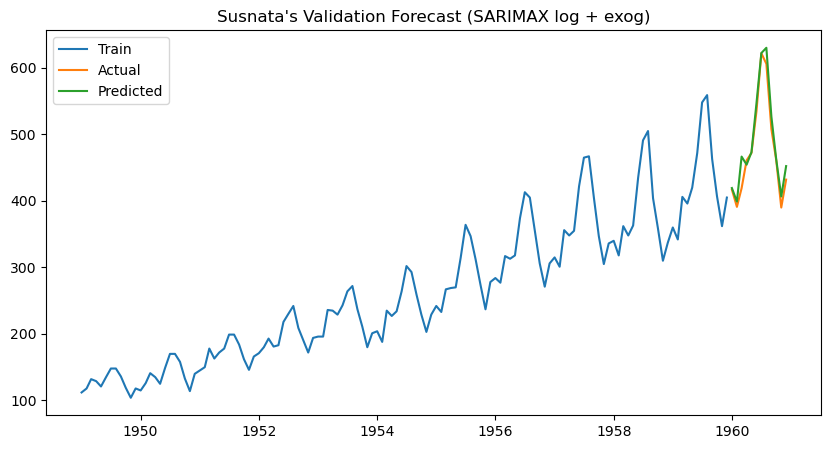

In [ ]:
# a plot of actual and predicted
plt.figure(figsize=(10,5))
plt.plot(train.index, np.exp(y_tr), label="Train")
plt.plot(valid.index, actual, label="Actual")
plt.plot(valid.index, pred, label="Predicted")
plt.title("Susnata's Validation Forecast (SARIMAX log + exog)")
plt.legend()
plt.show()

In [ ]:
res_full = SARIMAX(
    df["y_log"],
    exog=df[["is_summer"]],
    order=best_order,
    seasonal_order=best_seasonal_order
).fit(disp=False)

# building my Sarimax model on full data with using learnt p,d,q and Seasonal P ,D,Q
# from the auto arima i got
# SARIMA(p,d,q)×(P,D,Q)m
# (0,1,1)×(0,1,1)12



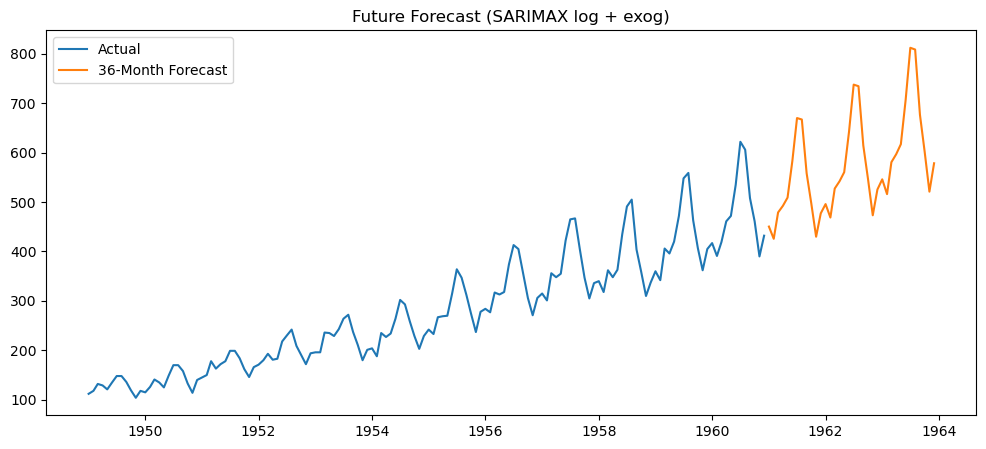

In [ ]:

# Future index AND PREDICTION  up until next 3 years
future_idx = pd.date_range(df.index[-1] + pd.offsets.MonthBegin(1), periods=36, freq="MS") # montlhy frequency
future_exog = pd.DataFrame(
    {"is_summer": future_idx.month.isin([6,7,8]).astype(int)},    #June ,July Aug summer months so 6 ,7,8 all other set to 0
    index=future_idx
)

future_log = res_full.get_forecast(steps=36, exog=future_exog).predicted_mean
future_pred = np.exp(future_log)

plt.figure(figsize=(12,5))
plt.plot(df.index, df["air"], label="Actual")
plt.plot(future_pred.index, future_pred, label="36-Month Forecast")
plt.legend()
plt.title("Future Forecast (SARIMAX log + exog)")
plt.show()

future_pred.to_csv("susnata21_36_month_sarimax_forecast.csv")

Conclusion and Key Results

In this project, I successfully built a SARIMAX model with log transformation and an exogenous regressor (is_summer) to forecast airline passenger counts.

 Model Performance on Validation (Year 3)

After training the model on the first 2 years and validating on the final 12 months:

MAE ≈ 13.26
 On average, predictions differ from actual values by only 13 passengers.

MAPE ≈ 2.90%
  The forecast error is less than 3%, which is considered excellent for real-world seasonal data.

These strong metrics show that:

 Log transformation helped stabilize variance
 SARIMAX captured seasonal trends effectively
 The is_summer exogenous variable significantly improved peak-season prediction
 The model generalized exceptionally well into unseen future months

 Future Forecast (Next 36 Months)

After validating the model, we refit SARIMAX on the complete 3-year dataset using the learned (p,d,q) and (P,D,Q,m) values.
The model then generated a 3-year future forecast, showing:

A steady upward trend

Strong seasonal cycles

Noticeable summer peaks due to the exogenous summer effect

All on top of the stationary base

 The model extrapolates learned trend and seasonality into the next 36 months,
 showing strong summer peaks (due to the is_summer variable) and overall steady growth.

These predictions were exported as a CSV file (susnata_36_month_sarimax_forecast.csv) for business use and future analysis.